<a href="https://colab.research.google.com/github/AchintyaX/GANs/blob/master/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing tensorflow 

import tensorflow as tf 

In [2]:
# To generate GIFs 
! pip install -q imageio

# checking the version of tensorflow 
print(tf.__version__)

2.2.0-rc3


In [0]:
import glob 
import imageio
import matplotlib.pyplot as plt 
import numpy as np
import os 
import PIL 
from tensorflow.keras import layers 
import time 

from IPython import display 

### Load and prepare the dataset

We will be using the classic MNIST dataset to train the generator and discriminator. 
It is obvious we will be developing handwritten digits resembling the MNIST data 

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5 #Normalize the images  to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

### Create the models

We are using Keras sequential API to design the architecture of the model 

In [0]:
# Generator 

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

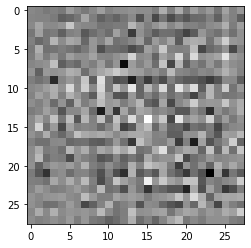

In [10]:
# Testing the output of the untrained Generator 

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
# Building the Discriminator 
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00353497]], shape=(1, 1), dtype=float32)


### Defining the loss and optimizers 

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
 # Definning the Discriminator loss 
 def discriminator_loss(real_output, fake_output):
     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
     total_loss = real_loss + fake_loss
     return total_loss

In [0]:
# Definning the Generator loss 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# definning the optimizers 
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Saving the checkpoints 

In [0]:
checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

# Definning the training loop
we will be providing a random seed input to the generator, the seed input is used to produce an image. 
The discrimnator is then used to classify real images ( from the training set) and fake images (produced by the generator ). THe  loss is calculated for each of these models, and the gradients are used to update the generator and discrimnator 

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# we will reuse this seed overtime (so its easier)
# to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of 'tf.function'
# This annotation causes the function to be "compiled" as graph code using tensorflow autograph 
@tf.function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [0]:
# Generate images and save them 
def generate_and_save_images(model, epoch, test_input):
    # Notice 'training' is set to False
    # So that all layers run in inference mode (batchnorm)

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.sublplot

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        
        # Produce images for the GIF as we go 
        display.clear_output(wait=True)
        generate_and_save_images(g)